# Tweet Emotion Recognition

## **Introduction**
This project focus to detect emotion of tweets using DAIR AI Emotion Dataset and it involves building and evaluating several machine learning and deep learning models, including SVM, Bidirectional LSTM, DistilBERT, BERT, and RoBERTa to determine which model achieves the highest performance in emotion detection.





## Import Libraries

In [1]:
# General libraries
import pandas as pd
import numpy as np
import re
import sys
import os
import random

# Add the root directory to sys.path
sys.path.append(os.path.abspath('..'))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import make_pipeline

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# load Hugging Face dataset
from datasets import load_dataset

## Load Data

In [2]:
dataset = load_dataset("emotion")
train_df = pd.DataFrame(dataset['train'])
test_df = pd.DataFrame(dataset['test'])
val_df = pd.DataFrame(dataset['validation'])

print(train_df.head())
print(train_df['label'].unique())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

split/train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

split/validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

split/test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3
[0 3 2 5 4 1]


In [3]:
train_df.shape, val_df.shape, test_df.shape

((16000, 2), (2000, 2), (2000, 2))

In [4]:
train_df.tail()

,text,label
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3
15999,i know a lot but i feel so stupid because i ca...,0


In [5]:
val_df.tail()

,text,label
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1
1999,i feel like i just wanna buy any cute make up ...,1


In [6]:
train_df["label"].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


In [7]:
val_df["label"].value_counts()

,count
label,
1,704
0,550
3,275
4,212
2,178
5,81


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [9]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [10]:
# Map label ID to label name
train_label_names = dataset["train"].features["label"].names
val_label_names = dataset["validation"].features["label"].names
test_label_names = dataset["test"].features["label"].names

def get_tweets(dataset):
    tweets = []
    labels = []
    for sample in dataset:
        tweets.append(sample['text'])
        labels.append(train_label_names[sample['label']])  # convert ID to label name
    return tweets, labels

train_tweets, train_labels = get_tweets(dataset["train"])
train_tweets[1], train_labels[1]

val_tweets, val_labels = get_tweets(dataset["validation"])
val_tweets[1], val_labels[1]

test_tweets, test_labels = get_tweets(dataset["test"])
test_tweets[1], test_labels[1]


('im updating my blog because i feel shitty', 'sadness')

In [11]:
for i, label in enumerate(train_label_names):
    print(f"Label {i}: {label}")

Label 0: sadness
Label 1: joy
Label 2: love
Label 3: anger
Label 4: fear
Label 5: surprise


## Visualize Data

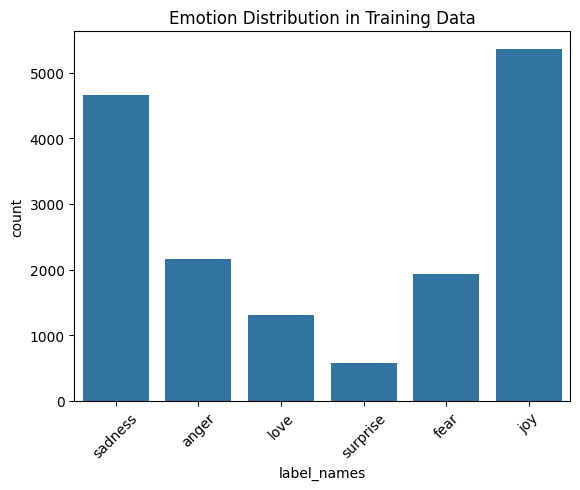

In [12]:
# Map label ID to label name in train_df
train_df['label_names'] = train_df['label'].map(lambda x: train_label_names[x])

sns.countplot(x='label_names', data=train_df)
plt.title('Emotion Distribution in Training Data')
plt.xticks(rotation=45) # Rotate labels for better readability
plt.show()

Here we can see class imbalnce.

## 1. Experiment With Suport Vector Machine

In [24]:
train_df_svm = pd.concat([train_df, val_df], ignore_index=True)
test_df_svm = test_df.copy()

# Drop the label_names column
train_df_svm = train_df_svm.drop('label_names', axis=1)

print("Shape of train_df_svm:", train_df_svm.shape)
print("Shape of test_df_svm:", test_df_svm.shape)

Shape of train_df_svm: (18000, 2)
Shape of test_df_svm: (2000, 2)


### Preprocess text

In [25]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)         # remove links
    text = re.sub(r'@\w+', '', text)            # remove mentions
    text = re.sub(r'[^a-z\s]', '', text)        # remove punctuation/numbers
    return text


train_df_svm['text'] = train_df_svm['text'].apply(clean_text)
test_df_svm['text'] = test_df_svm['text'].apply(clean_text)

### Get train set and test set

In [26]:
X_train, y_train = train_df_svm['text'], train_df_svm['label']
X_test, y_test = test_df_svm['text'], test_df_svm['label']

### Compute Class Weights

In [28]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

for label, weight in class_weights_dict.items():
    print(f"Label {label}: {weight:.3f}")

Label 0: 0.575
Label 1: 0.495
Label 2: 2.024
Label 3: 1.233
Label 4: 1.396
Label 5: 4.594


### Make pipeline with Text to Vectors (TF-IDF) and LinearSVC

In [29]:
vectorizer = TfidfVectorizer()
svm = LinearSVC(class_weight=class_weights_dict)

pipeline = make_pipeline(
    vectorizer,
    svm
)

In [30]:
pipeline

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc',
                 LinearSVC(class_weight={0: np.float64(0.5751533742331288),
                                         1: np.float64(0.49455984174085066),
                                         2: np.float64(2.0242914979757085),
                                         3: np.float64(1.2325390304026294),
                                         4: np.float64(1.3959981386691485),
                                         5: np.float64(4.594180704441041)}))])

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc',
                 LinearSVC(class_weight={0: np.float64(0.5751533742331288),
                                         1: np.float64(0.49455984174085066),
                                         2: np.float64(2.0242914979757085),
                                         3: np.float64(1.2325390304026294),
                                         4: np.float64(1.3959981386691485),
                                         5: np.float64(4.594180704441041)}))])

In [32]:
pipeline.score(X_test, y_test)

0.8935

### Hyperparameter Tuning of SVM Using GridSearchCV

#### Define hyperparameters

In [41]:
param_grid = {
    'linearsvc__C': [0.01, 0.1, 1, 5, 10],
    'linearsvc__loss': ['hinge', 'squared_hinge'],
    'linearsvc__max_iter': [1000, 3000, 5000]
}

In [42]:
# Use GridSearchCV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit on training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('linearsvc',
                                        LinearSVC(class_weight={0: np.float64(0.5751533742331288),
                                                                1: np.float64(0.49455984174085066),
                                                                2: np.float64(2.0242914979757085),
                                                                3: np.float64(1.2325390304026294),
                                                                4: np.float64(1.3959981386691485),
                                                                5: np.float64(4.594180704441041)}))]),
             n_jobs=-1,
             param_grid={'linearsvc__C': [0.01, 0.1, 1, 5, 10],
                         'linearsvc__loss': ['hinge', 'squared_hinge'],
                         'linearsvc__max_iter': [1000, 3000, 5000]},
             scoring='f1_weighted', verbose=2)

### Best Hyperparameters

In [43]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'linearsvc__C': 1, 'linearsvc__loss': 'hinge', 'linearsvc__max_iter': 1000}
Best F1 Score: 0.8946850597366527


In [48]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('linearsvc',
                 LinearSVC(C=1,
                           class_weight={0: np.float64(0.5751533742331288),
                                         1: np.float64(0.49455984174085066),
                                         2: np.float64(2.0242914979757085),
                                         3: np.float64(1.2325390304026294),
                                         4: np.float64(1.3959981386691485),
                                         5: np.float64(4.594180704441041)},
                           loss='hinge'))])

### Model evalution with testing data

In [49]:
final_pred = best_model.predict(X_test)

print("Tuned Model Accuracy:", accuracy_score(y_test, final_pred))
print(classification_report(y_test, final_pred, target_names=test_label_names))

Tuned Model Accuracy: 0.892
              precision    recall  f1-score   support

     sadness       0.96      0.91      0.94       581
         joy       0.96      0.88      0.92       695
        love       0.70      0.96      0.81       159
       anger       0.87      0.90      0.89       275
        fear       0.86      0.84      0.85       224
    surprise       0.59      0.82      0.68        66

    accuracy                           0.89      2000
   macro avg       0.82      0.89      0.85      2000
weighted avg       0.90      0.89      0.90      2000



### Save the best model

In [51]:
import pickle

# Save the best model
with open('best_svm_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Let's look at where the model performed well and where model failed. The following code block displays random examples of correctly and incorrectly predicted tweets from the test set.

In [50]:
import random

# Get the true labels and predictions
y_true = y_test
y_pred = final_pred

# Get the text samples
X_samples = X_test

# Create lists to store correct and incorrect predictions
correct_predictions = []
incorrect_predictions = []

# Iterate through the test samples and compare predictions with true labels
for i in range(len(X_samples)):
    text = X_samples.iloc[i]
    true_label = y_true.iloc[i]
    predicted_label = y_pred[i]

    # Map label IDs to names
    true_label_name = test_label_names[true_label]
    predicted_label_name = test_label_names[predicted_label]

    if true_label == predicted_label:
        correct_predictions.append({
            'text': text,
            'true_label': true_label_name,
            'predicted_label': predicted_label_name
        })
    else:
        incorrect_predictions.append({
            'text': text,
            'true_label': true_label_name,
            'predicted_label': predicted_label_name
        })

# Display a few random correct predictions
print("--- Random Correct Predictions ---")
for _ in range(min(5, len(correct_predictions))):
    prediction = random.choice(correct_predictions)
    print(f"Text: {prediction['text']}")
    print(f"True Label: {prediction['true_label']}")
    print(f"Predicted Label: {prediction['predicted_label']}")
    print("-" * 20)

# Display a few random incorrect predictions
print("\n--- Random Incorrect Predictions ---")
for _ in range(min(5, len(incorrect_predictions))):
    prediction = random.choice(incorrect_predictions)
    print(f"Text: {prediction['text']}")
    print(f"True Label: {prediction['true_label']}")
    print(f"Predicted Label: {prediction['predicted_label']}")
    print("-" * 20)

--- Random Correct Predictions ---
Text: im feeling adventurous i might even make it multiple tiers too
True Label: joy
Predicted Label: joy
--------------------
Text: i suppose i feel too trusting sometimes
True Label: joy
Predicted Label: joy
--------------------
Text: i have faith in supreme power and i accept everything and all incidence occuring in life sometimes like today it really makes me feel very very dull and i start crying
True Label: sadness
Predicted Label: sadness
--------------------
Text: i feel shy to admit that i was struggling to haul a single computer up
True Label: fear
Predicted Label: fear
--------------------
Text: i see all my friends posting pics and status updates of where they are going or what they are doing and i feel a bit jealous knowing it s not something i can get out and enjoy
True Label: anger
Predicted Label: anger
--------------------

--- Random Incorrect Predictions ---
Text: i go again sometime in the future id probably just stick with the afr

Upon examining some of the incorrect predictions, it's worth noting that in certain instances, the model's predicted label appears to be a plausible interpretation of the text, suggesting potential inconsistencies or ambiguities in the original dataset's labeling.

For example:

*   **Text:** `i actually feel agitated which led to a terrible day yesterday in which i was unable to concentrate on anything and basically piddled the day away`
    *   **True Label:** anger
    *   **Predicted Label:** sadness
    In this case, "sadness" could be argued as a reasonable emotion given the context of a "terrible day" and inability to concentrate.

*   **Text:** `i know is that she s here and i m so thankful for her warm loving and peaceful presence i feel when my anger or feelings of discontent and frustration flare up`
    *   **True Label:** sadness
    *   **Predicted Label:** love
    Here, the text explicitly mentions "warm loving and peaceful presence," which aligns well with the "love" prediction, even though the true label is "sadness."

These examples highlight the challenges of emotion recognition in text and suggest that a perfect score might be unattainable due to the inherent subjectivity and potential for ambiguous labeling in the dataset.

## 2. Experiment With Bidirectional LSTM

TBC